In [2]:
# importing the necessary libraries for this project

import pandas as pd
import requests
from bs4 import BeautifulSoup
import numpy as np 
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans 
from sklearn.metrics import silhouette_score
from mpl_toolkits.mplot3d import Axes3D

# Reading the S and P 500 CSV file into a DataFrame
df = pd.read_csv('/Users/rhoda/Downloads/sp500_companies.csv')

# Cleaning to select just the columns needed
selected_columns = df[['Sector', 'Symbol', 'Longname', 'Longbusinesssummary']]

# Grouping the companies by sector
grouped_by_sector = selected_columns.groupby('Sector')['Symbol'].apply(list).to_dict()

sector_list = grouped_by_sector.keys()
    

# Ask user to pick the sector their stock is in
sector_pick = input("Which of the following sectors does your company fall under?: 'Basic Materials', 'Communication Services', 'Consumer Cyclical', 'Consumer Defensive', 'Energy', 'Financial Services', 'Healthcare', 'Industrials', 'Real Estate', 'Technology', 'Utilities' ")

# Check if the selected sector is valid for the dataset
if sector_pick in sector_list:
    print("You've selected the " + sector_pick + " sector")
    
    # Ask the user to input a stock
    stock_symbol = input("What is the ticker symbol of your company? ").upper()
else: 
    print("Invalid sector selection. Please select a valid sector from the list.")

# Define the URL for Yahoo Finance for the stock
url = f'https://finance.yahoo.com/quote/{stock_symbol}'

# Send a GET request to the URL and retrieve the page content
response = requests.get(url)

# Check if the request was successful (status code 200)
if response.status_code == 200:
    # Parse the page content with BeautifulSoup
    soup = BeautifulSoup(response.content, 'html.parser')

    # Find elements that contain the data we want, ps stands for picked stock
    ps_pe_ratio = soup.find('td', {'data-test': 'PE_RATIO-value'})
    ps_beta = soup.find('td', {'data-test': 'BETA_5Y-value'})
    ps_forward_dividend_yield = soup.find('td', {'data-test': 'DIVIDEND_AND_YIELD-value'})

    # Extract the significant text from the found elements
    ps_pe_ratio_value = ps_pe_ratio.text if ps_pe_ratio else 'N/A'
    ps_beta_value = ps_beta.text if ps_beta else 'N/A'
    ps_dividend_yield_value = ps_forward_dividend_yield.text if  ps_forward_dividend_yield else 'N/A'

    # Convert extracted values to appropriate data types and handle 'N/A'
    if ps_pe_ratio_value != 'N/A':
            ps_pe_ratio_value = float(ps_pe_ratio_value.replace(',', ''))
    else:
            ps_pe_ratio_value = np.nan

    if ps_beta_value != 'N/A':
            ps_beta_value = float(ps_beta_value)
    else:
            ps_beta_value = np.nan

    if ps_forward_dividend_yield:
        # Split the text by space and take the first part, then replace commas
        dividend_yield_parts = ps_forward_dividend_yield.text.split(' ')
        ps_dividend_yield_value = dividend_yield_parts[0].replace(',', '') if dividend_yield_parts[0] != 'N/A' else np.nan
    else:
        ps_dividend_yield_value = np.nan


    # Print the results for the selected stock
    print(f'Stock Symbol: {stock_symbol}')
    print(f'P/E Ratio: {ps_pe_ratio_value}')
    print(f'Beta: {ps_beta_value}')
    print(f'Forward Dividend & Yield: {ps_dividend_yield_value}')
 
# Initialize an empty list to store data for all stocks in the selected sector
data = []

# Loop through companies in the selected sector
for company in grouped_by_sector[sector_pick]:
    
    url = f'https://finance.yahoo.com/quote/{company}'
    
    # Send a GET request to the URL and retrieve the page content for each company
    response = requests.get(url)

    # Check if the request was successful (status code 200)
    if response.status_code == 200:
        # Parse the page content with BeautifulSoup
        soup = BeautifulSoup(response.content, 'html.parser')

        # Find elements that contain the data we want for each company
        pe_ratio = soup.find('td', {'data-test': 'PE_RATIO-value'})
        beta = soup.find('td', {'data-test': 'BETA_5Y-value'})
        forward_dividend_yield = soup.find('td', {'data-test': 'DIVIDEND_AND_YIELD-value'})

        # Extract the text from the found elements
        pe_ratio_value = pe_ratio.text if pe_ratio else 'N/A'
        beta_value = beta.text if beta else 'N/A'
        dividend_yield_value = forward_dividend_yield.text if forward_dividend_yield else 'N/A'

        # Convert extracted values to appropriate data types and handle 'N/A'
        if pe_ratio_value != 'N/A':
            pe_ratio_value = float(pe_ratio_value.replace(',', ''))
        else:
            pe_ratio_value = np.nan

        if beta_value != 'N/A':
            beta_value = float(beta_value)
        else:
            beta_value = np.nan

        if dividend_yield_value != 'N/A':
            dividend_yield_value = dividend_yield_value.split(' ')[0]  # Extract dividend value
            dividend_yield_value = float(dividend_yield_value.replace(',', ''))
        else:
            dividend_yield_value = np.nan
            print("Stock data is missing one of the values needed")
            exit

        # Append data for the current company to the list
        data.append({
            "Company": company,
            "PE Ratio": pe_ratio_value,
            "Dividend": dividend_yield_value,
            "Beta": beta_value
        })

# Convert the list of data to a DataFrame
df = pd.DataFrame(data)

# Define a function to calculate Euclidean distance between a user's stock and others
def calculate_euclidean_distance(row, user_stock):
    """
    Calculate the Euclidean distance between a user's stock and another stock based on their financial data.

    Parameters:
        row (pd.Series): A row representing a stock's financial data.
        user_stock (dict): The user's input stock details.

    Returns:
        float: The Euclidean distance between the two stocks.
    """
    # Calculate the squared differences between financial data components
    
    distance_components = [
        (float(row['PE Ratio']) - float(user_stock['PE Ratio']))**2,
        (float(row['Dividend']) - float(user_stock['Dividend']))**2,
        (float(row['Beta']) - float(user_stock['Beta']))**2
    ]
    
    # Only calculate distance if none of the components are NaN
    if not any(np.isnan(component) for component in distance_components):
        return np.sqrt(sum(distance_components))
    else:
        return np.nan 


# User's input stock details 
user_stock = {'Company symbol': stock_symbol, 'PE Ratio': ps_pe_ratio_value, 'Dividend': ps_dividend_yield_value, 'Beta': ps_beta_value}

# Exclude the user's company from the DataFrame
df_filtered = df[df['Company'] != user_stock['Company symbol']].copy()

# Calculate the Euclidean distance for each company in the DataFrame
df_filtered['Distance'] = df_filtered.apply(lambda row: calculate_euclidean_distance(row, user_stock), axis=1)
df_sorted = df_filtered.sort_values(by='Distance')

# Print the DataFrame sorted by similarity
print(df_sorted)

# Find the company with the smallest Euclidean distance (most similar)
most_sim_company = df_sorted.iloc[0]
second_most_sim = df_sorted.iloc[1]
third_most_sim = df_sorted.iloc[2]

# Retrieve the full name and description of the most similar company
most_sim_company_symbol = most_sim_company['Company']
most_sim_company_name = selected_columns.loc[selected_columns['Symbol'] == most_sim_company_symbol, 'Longname'].iloc[0]
most_sim_company_description = selected_columns.loc[selected_columns['Symbol'] == most_sim_company_symbol, 'Longbusinesssummary'].iloc[0]

# Retrieve the full name and description of the second most similar company
second_sim_company_symbol = second_most_sim['Company']
second_sim_company_name = selected_columns.loc[selected_columns['Symbol'] == second_sim_company_symbol, 'Longname'].iloc[0]
second_sim_company_description = selected_columns.loc[selected_columns['Symbol'] == second_sim_company_symbol, 'Longbusinesssummary'].iloc[0]

# Retrieve the full name and description of the third most similar company
third_sim_company_symbol = third_most_sim['Company']
third_sim_company_name = selected_columns.loc[selected_columns['Symbol'] == third_sim_company_symbol, 'Longname'].iloc[0]
third_sim_company_description = selected_columns.loc[selected_columns['Symbol'] == third_sim_company_symbol, 'Longbusinesssummary'].iloc[0]

# Display the names of the 3 most similar companies
print(f"The top 3 most similar companies are:\n"
      f"1: {most_sim_company_name} ({most_sim_company_symbol})\n"
      f"2: {second_sim_company_name} ({second_sim_company_symbol})\n"
      f"3: {third_sim_company_name} ({third_sim_company_symbol})")

# Ask the user if they want to see descriptions of the companies
user_description_response = input("Would you like to see the descriptions of the companies (yes/no): ").strip().lower()

# Display descriptions if the user wants
if user_description_response in ['yes', 'y']:
    print("Description of " + most_sim_company_name + " : " + most_sim_company_description)
    print()
    print("Description of " + second_sim_company_name + " : " + second_sim_company_description)
    print()
    print("Description of " + third_sim_company_name + " : " + third_sim_company_description)


Which of the following sectors does your company fall under?: 'Basic Materials', 'Communication Services', 'Consumer Cyclical', 'Consumer Defensive', 'Energy', 'Financial Services', 'Healthcare', 'Industrials', 'Real Estate', 'Technology', 'Utilities' Utilities
You've selected the Utilities sector
What is the ticker symbol of your company? NEE
Stock Symbol: NEE
P/E Ratio: 15.13
Beta: 0.54
Forward Dividend & Yield: 1.87
   Company  PE Ratio  Dividend  Beta   Distance
3        D     15.43      2.67  0.53   0.854459
21    EVRG     16.78      2.57  0.55   1.792373
4      SRE     16.84      2.38  0.75   1.796747
8       ED     13.34      3.24  0.38   2.259779
24      NI     17.26      1.00  0.50   2.301174
22     LNT     17.47      1.81  0.57   2.340961
15     AEE     17.42      2.52  0.49   2.380987
11      ES     17.43      2.70  0.56   2.445261
13     DTE     16.88      3.81  0.65   2.614995
26     PNW     17.27      3.52  0.51   2.702406
16     ETR     14.35      4.52  0.68   2.765954
6

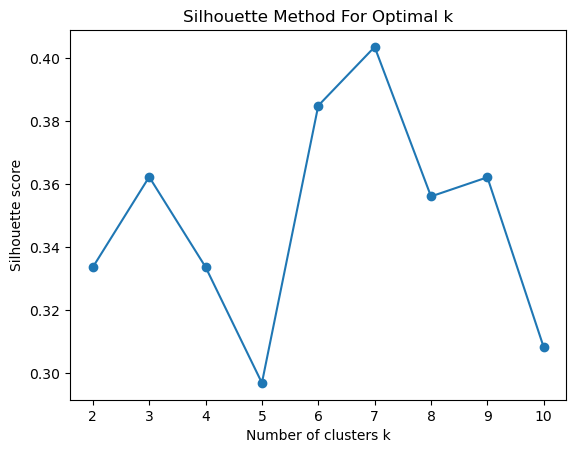

In [3]:
# Check if 'ps_pe_ratio_value' is NaN, and if so, print a warning message
if pd.isna(ps_pe_ratio_value):
    print("The K clustering algorithm for this company cannot be done with a value of NaN")
# Check if 'ps_beta_value' is NaN, and if so, print a warning message
elif pd.isna(ps_beta_value):
    print("The K clustering algorithm for this company cannot be done with a value of NaN")
# Check if 'ps_dividend_yield_value' is NaN, and if so, print a warning message
elif pd.isna(ps_dividend_yield_value):
    print("The K clustering algorithm for this company cannot be done with a value of NaN")

# Create a copy of the DataFrame 'df' with rows containing NaN values in 'PE Ratio', 'Dividend', or 'Beta' dropped
df_numeric = df.dropna(subset=['PE Ratio', 'Dividend', 'Beta']).copy()

# Data for the user's chosen company
user_company_data = {
    'Company': stock_symbol,
    'PE Ratio': ps_pe_ratio_value,  # Example data
    'Dividend': ps_dividend_yield_value,   # Example data
    'Beta': ps_beta_value       # Example data
}

# Create a DataFrame for the specific company
user_company_df = pd.DataFrame([user_company_data])

# Append the specific company's DataFrame to df_numeric
df_numeric = pd.concat([df_numeric, user_company_df], ignore_index=True)

# Convert 'PE Ratio', 'Dividend', and 'Beta' columns to numeric, handling errors with 'coerce' to convert non-numeric to NaN
df_numeric['PE Ratio'] = pd.to_numeric(df_numeric['PE Ratio'], errors='coerce')
df_numeric['Dividend'] = pd.to_numeric(df_numeric['Dividend'], errors='coerce')
df_numeric['Beta'] = pd.to_numeric(df_numeric['Beta'], errors='coerce')

# Drop rows with NaN values in 'PE Ratio', 'Dividend', or 'Beta'
df_numeric.dropna(subset=['PE Ratio', 'Dividend', 'Beta'], inplace=True)

# Create a list to store longnames of companies
sector_longnames = []

# Extract longnames for all companies except the user's company
for company in df_numeric['Company'][:-1]:
    longname = selected_columns.loc[selected_columns['Symbol'] == company, 'Longname'].values[0]
    sector_longnames.append(longname)

# Append the longname of the user's company to the list
sector_longnames.append(stock_symbol)
    
# Add a new column 'CompanyName' to 'df_numeric' with the longnames
df_numeric['CompanyName'] = sector_longnames

# Extract the relevant features for clustering
features = df_numeric[['PE Ratio', 'Dividend', 'Beta']]

# Standardize the features
scaler = StandardScaler()
features_scaled = scaler.fit_transform(df_numeric[['PE Ratio', 'Dividend', 'Beta']])

# Calculate silhouette score for different k values
silhouette_scores = []
for k in range(2, 11):  # Silhouette score is not defined for k=1
    kmeans = KMeans(n_clusters=k, random_state=0, n_init = 10)
    cluster_labels = kmeans.fit_predict(features_scaled)
    silhouette_scores.append(silhouette_score(features_scaled, cluster_labels))

# Plot Silhouette scores against the number of clusters (k)
plt.plot(range(2, 11), silhouette_scores, marker='o')  # Adjust range accordingly
plt.xlabel('Number of clusters k')
plt.ylabel('Silhouette score')
plt.title('Silhouette Method For Optimal k')
plt.show()

# Find the index of the highest silhouette score
optimal_k_index = np.argmax(silhouette_scores)

# Find the optimal number of clusters from the silhouette scores
optimal_k = range(2, 11)[optimal_k_index]  # Adjust the range if necessary


          PE Ratio  Dividend      Beta
Cluster                               
0        18.675000  2.665000  0.810000
1        16.398182  2.073636  0.543636
2        39.290000  1.640000  0.470000
3        17.164000  3.492000  0.458000
4        23.480000  0.880000  0.875000
5        26.140000  2.805000  0.590000
6        16.570000  3.850000  0.660000


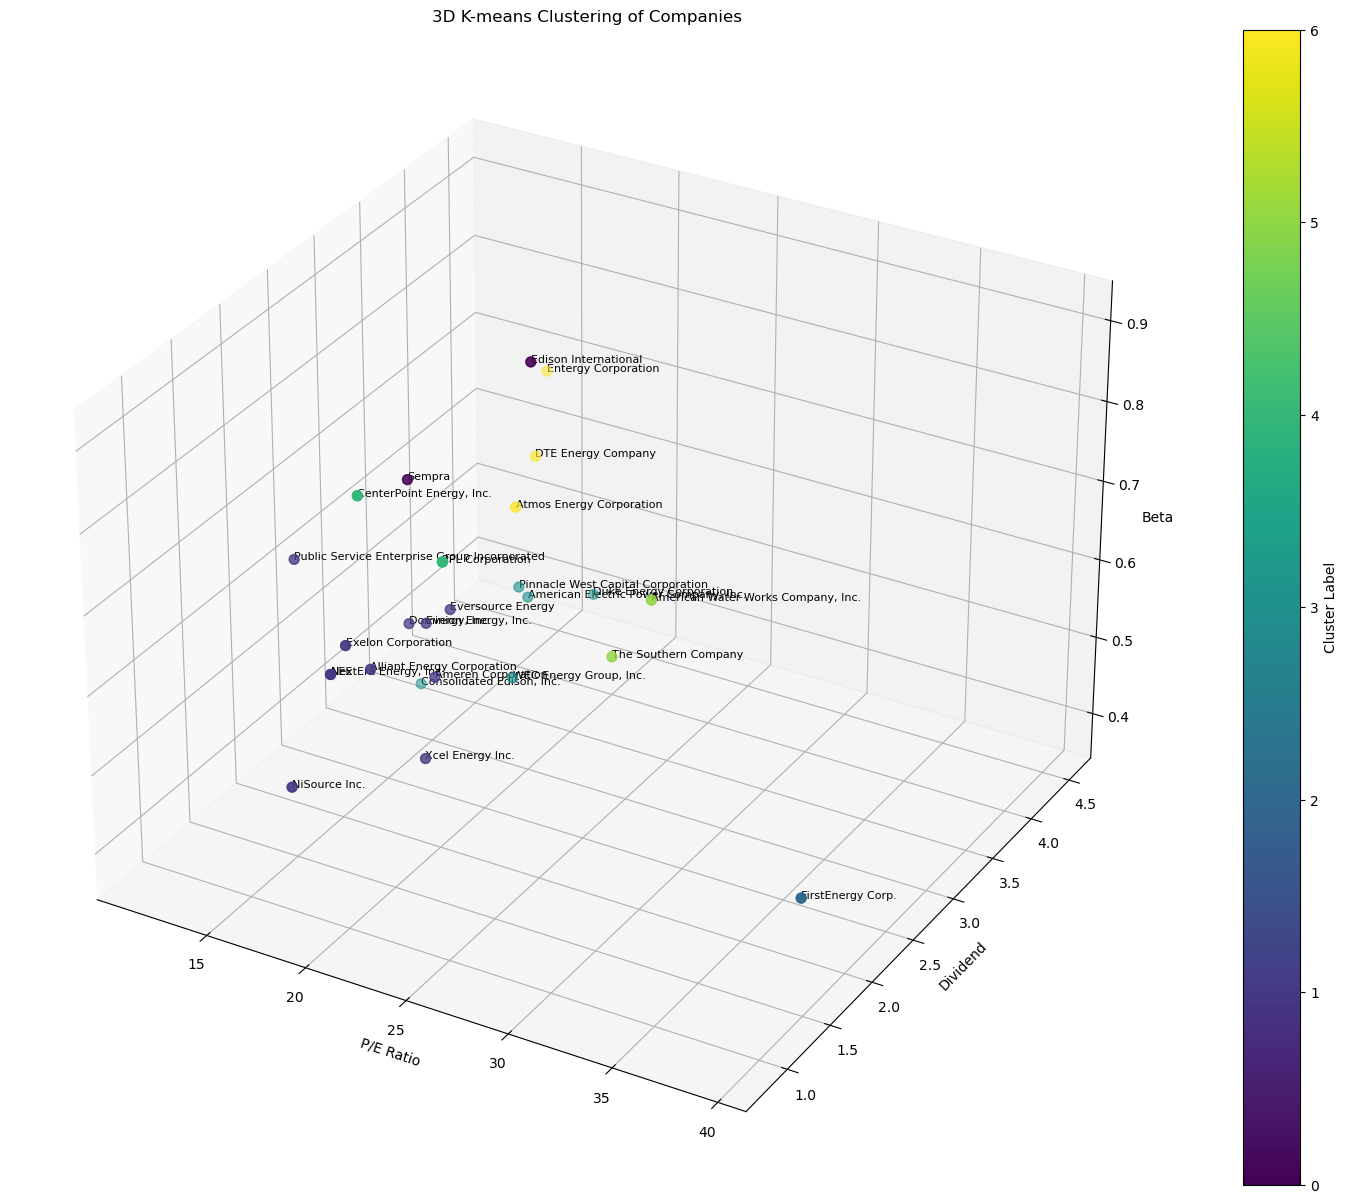

In [4]:
# Assign the optimal number of clusters to 'k'
k = optimal_k

# Initialize the KMeans clustering model with 'k' clusters, setting a random seed for reproducibility
kmeans = KMeans(n_clusters=k, random_state=0, n_init = 10)

# Perform K-means clustering on the standardized features
clusters = kmeans.fit_predict(features_scaled)

# Add the cluster information to the DataFrame
df_numeric['Cluster'] = clusters

# Display the mean values of numeric columns for each cluster
print(df_numeric.groupby('Cluster').mean(numeric_only = 'True'))

# Create a 3D scatter plot to visualize the K-means clustering results
fig = plt.figure(figsize=(20, 15))
ax = fig.add_subplot(111, projection='3d')

# Initialize empty lists to store data for the plot
pe_ratios = []
dividends = []
betas = []
colors = []

# Iterate through each row in 'df_numeric' to extract data for the plot
for index, row in df_numeric.iterrows():
    pe_ratios.append(row['PE Ratio'])
    dividends.append(row['Dividend'])
    betas.append(row['Beta'])
    colors.append(row['Cluster'])
    
# Scatter plot with color-coded clusters
ax.scatter(pe_ratios, dividends, betas, c=colors, cmap='viridis', s=50)

# Add company names as labels to the data points
for i, txt in enumerate(df_numeric['CompanyName']):
    ax.text(df_numeric['PE Ratio'].iloc[i], 
            df_numeric['Dividend'].iloc[i], 
            df_numeric['Beta'].iloc[i], 
            '%s' % (txt), size=8, zorder=1)

# Set axes labels
ax.set_xlabel('P/E Ratio')
ax.set_ylabel('Dividend')
ax.set_zlabel('Beta')

# Set the title and color bar of the 3D scatter plot
plt.title('3D K-means Clustering of Companies')
color_bar = plt.colorbar(ax.scatter(pe_ratios, dividends, betas, c=colors, cmap='viridis', s=50))
color_bar.set_label('Cluster Label')

# other viewing options include (ax.view_init(elev=60, azim=60)) or (ax.view_init(elev=20, azim=0))

# Show the plot
plt.show()



In [5]:
# Companies that are closer together in the 3D space
# and share the same color are considered to be more similar to 
# each other according to the features used. Scaling does account for differentiation 
# between Euclidean distance results and results from the above graph

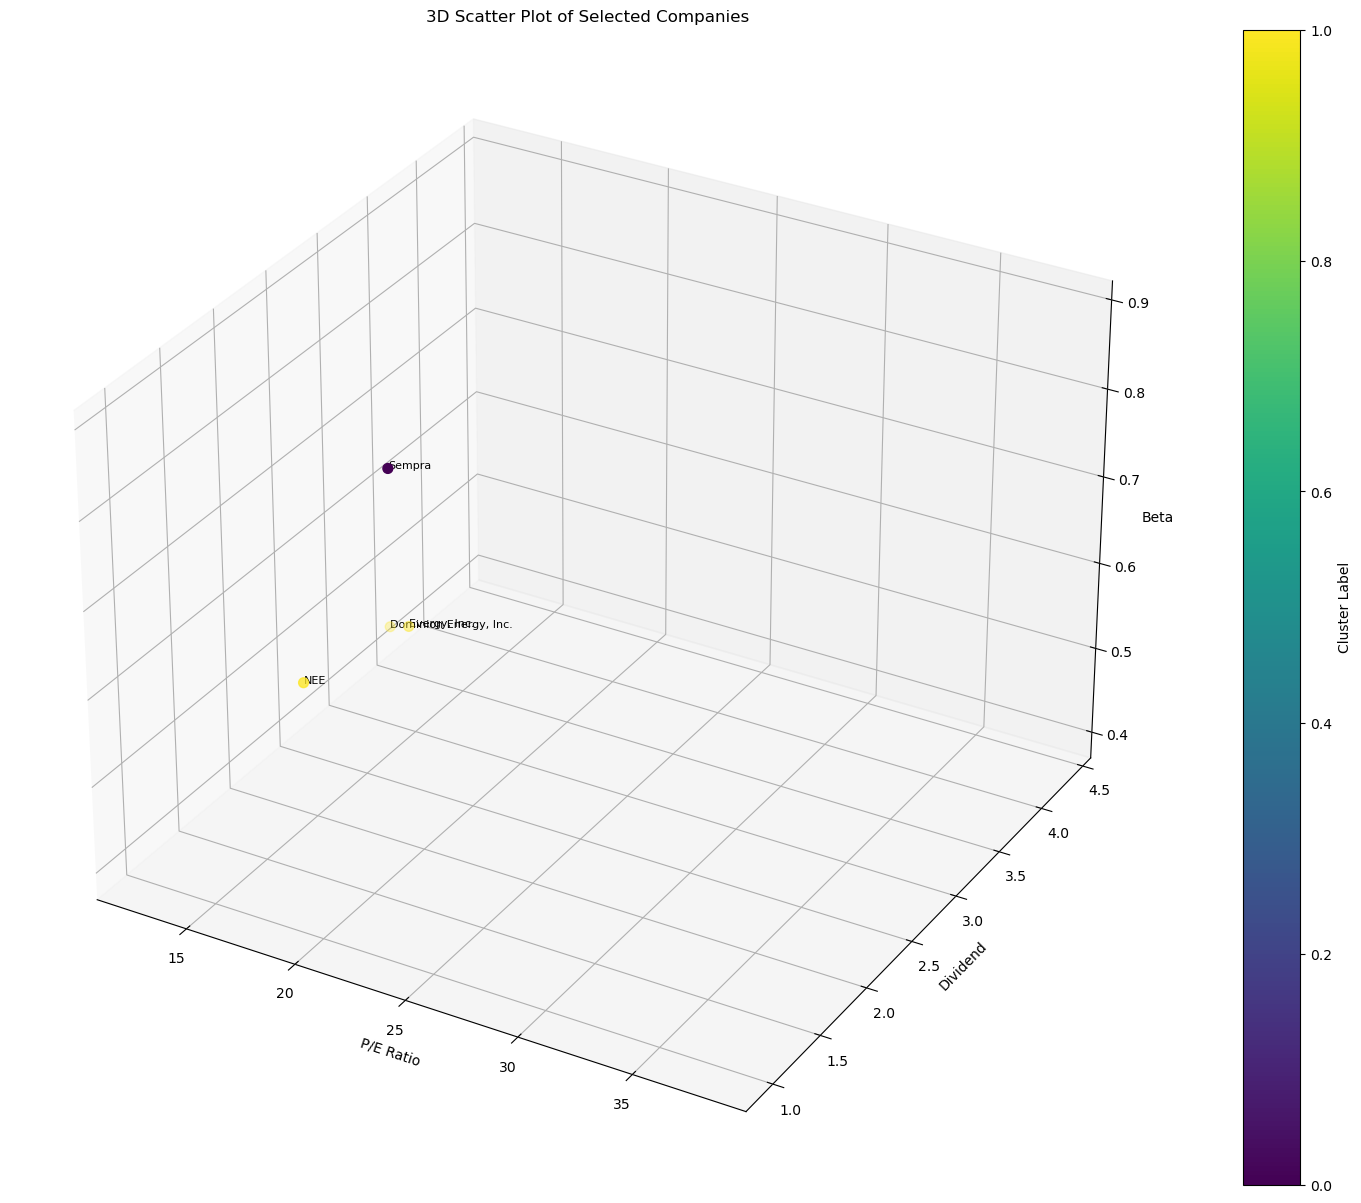

In [6]:
# Create a list of the top 3 similar companies plus the user's picked stock symbol
top_3_companies_plus_picked_stock = [most_sim_company_name, second_sim_company_name, third_sim_company_name, stock_symbol]

# Define the limits for the x, y, and z axes based on the data
x_lim = (min(pe_ratios), max(pe_ratios))
y_lim = (min(dividends), max(dividends))
z_lim = (min(betas), max(betas))

# Create a 3D scatter plot for the selected companies
fig = plt.figure(figsize=(20, 15))
ax = fig.add_subplot(111, projection='3d')

# Initialize lists to store data for the selected companies
pe_ratios_2 = []
dividends_2 = []
betas_2 = []
colors_2 = []

# Iterate through the DataFrame to extract data for the selected companies
for index, row in df_numeric.iterrows():
    if row['CompanyName'] in top_3_companies_plus_picked_stock:
        pe_ratios_2.append(row['PE Ratio'])
        dividends_2.append(row['Dividend'])
        betas_2.append(row['Beta'])
        colors_2.append(row['Cluster'])

# Create the scatter plot for the selected companies
scatter = ax.scatter(pe_ratios_2, dividends_2, betas_2, c=colors_2, cmap='viridis', s=50)

# Add labels to the data points
for i, txt in enumerate(df_numeric['CompanyName']):
    if txt in top_3_companies_plus_picked_stock:
        ax.text(df_numeric['PE Ratio'].iloc[i], 
            df_numeric['Dividend'].iloc[i], 
            df_numeric['Beta'].iloc[i], 
            '%s' % (txt), size=8, zorder=1)

# Set labels for the axes
ax.set_xlabel('P/E Ratio')
ax.set_ylabel('Dividend')
ax.set_zlabel('Beta')

# Set limits for the axes based on the defined limits
ax.set_xlim(x_lim)
ax.set_ylim(y_lim)
ax.set_zlim(z_lim)

# Set the title and color bar of the 3D scatter plot
plt.title('3D Scatter Plot of Selected Companies')
color_bar = plt.colorbar(scatter)
color_bar.set_label('Cluster Label')

# Show the plot
plt.show()


## PART 2: Machine Learning and Stock Price Prediction

What is the ticker symbol for the company you would like to invest in? AAPL
[*********************100%%**********************]  1 of 1 completed
Mean Squared Error: 7.7995516892787435
R-squared: 0.9824121524857781
[*********************100%%**********************]  1 of 1 completed
Predicted Stock Prices for 2021:
[131.94379707 128.9732003  127.37917152 128.9732003  128.41650337
 131.95729691 129.5513002  128.9732003  131.95729691 128.446147
 129.44294907 128.41650337 134.14909676 134.14909676 134.14909676
 134.14909676 134.14909676 134.14909676 128.41650337 132.0164962
 133.00679909 131.59679626 134.14909676 134.14909676 134.14909676
 134.14909676 133.00679909 133.00679909 133.00679909 131.1275972
 128.9732003  131.95189674 132.47909637 125.69162224 125.69162224
 125.05017601 115.39759964 119.37620117 129.44294907 125.46520126
 125.75689804 119.25399872 121.93590073 115.14120163 119.11040115
 119.19569916 125.72509811 115.42520004 124.5920977  125.05769852
 128.02459549 119.1189978  1

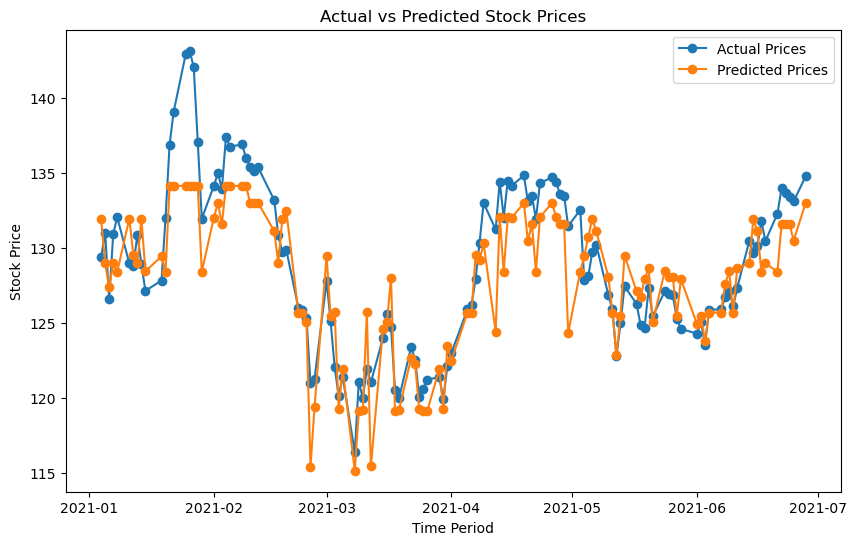

In [7]:
import yfinance as yf
import datetime
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

# Function to get historical data
def get_data(ticker_symbol, start_date, end_date):
    # Convert date strings to datetime objects
    start_date = datetime.datetime.strptime(start_date, "%Y-%m-%d")
    end_date = datetime.datetime.strptime(end_date, "%Y-%m-%d")
    
    # Download historical data using yfinance
    data = yf.download(ticker_symbol, start=start_date, end=end_date)
    return data

# Define ticker symbol and date range for initial historical data
company_want = input("What is the ticker symbol for the company you would like to invest in? ")
start_date = "2020-01-01"
end_date = "2020-12-31"

# Get historical data
historical_data = get_data(company_want, start_date, end_date)

# Feature Engineering: Use 'Close' as the feature and shift it to get the target variable
historical_data['Target'] = historical_data['Close'].shift(-1)
historical_data.dropna(inplace=True)  # Drop rows with NaN in the target variable

# Split the data into training and testing sets
X = historical_data[['Close']]
y = historical_data['Target']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train the model (using RandomForestRegressor for simplicity)
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Make predictions on the test set
predictions = model.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, predictions)
print(f'Mean Squared Error: {mse}')

# Assuming y_test and predictions are already defined
r_squared = r2_score(y_test, predictions)

print(f'R-squared: {r_squared}')

# Define date range for new historical data
start_date_new = "2021-01-01"
end_date_new = "2021-06-30"

# Get new historical data
historical_data_new = get_data(company_want, start_date_new, end_date_new)

# Feature Engineering: Use 'Close' as the feature and shift it to get the target variable
historical_data_new['Target'] = historical_data_new['Close'].shift(-1)
historical_data_new.dropna(inplace=True)  # Drop rows with NaN in the target variable

# Use the trained model to predict the stock price for the new data
new_data = pd.DataFrame({'Close': historical_data_new['Close']})
predicted_prices_new = model.predict(new_data)

# Display the predicted prices for the new data
print("Predicted Stock Prices for 2021:")
print(predicted_prices_new)

# Plotting actual vs predicted prices up to 2021-12-31
plt.figure(figsize=(10, 6))
plt.plot(historical_data_new.index, historical_data_new['Close'], label='Actual Prices', marker='o')
plt.plot(historical_data_new.index, predicted_prices_new, label='Predicted Prices', marker='o')
plt.xlabel('Time Period')
plt.ylabel('Stock Price')
plt.title('Actual vs Predicted Stock Prices')
plt.legend()

plt.show()
